In [1]:
import os
import h5py
import glob
import torch.utils.data as data
import torch.optim as optim
import torch.nn.init as init
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from display import get_cmap

vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)

In [2]:
torch.cuda.empty_cache()

In [3]:
with h5py.File('data/processed/nowcast_training_000.h5','r') as hf:
    print("Keys: %s" % hf.keys())
    print(len(hf['IN_vil']))

Keys: <KeysViewHDF5 ['IN_ir069', 'IN_ir107', 'IN_lght', 'IN_vil', 'OUT_vil']>
5088


In [4]:
from torchvision.transforms import Resize, Compose, ToTensor
class SevirDataset(data.Dataset):

    def __init__(self, root = '..', type = 'train'):
        
        DEST_TRAIN_FILE= os.path.join(root,'data/processed/nowcast_training_000.h5')
        DEST_TRAIN_META=os.path.join(root, 'data/processed/nowcast_training_000_META.csv')
        DEST_TEST_FILE= os.path.join(root, 'data/processed/nowcast_testing_000.h5')
        DEST_TEST_META= os.path.join(root, 'data/processed/nowcast_testing_000_META.csv')
        self.transform = Compose([ToTensor(),
                                    Resize(size=(48,48))])
        if type=='train':
            self.data_file = DEST_TRAIN_FILE
            self.meta_file = DEST_TRAIN_META 
        else:
            self.data_file = DEST_TEST_FILE
            self.meta_file = DEST_TEST_META

    def __getitem__(self, index):
                
        with h5py.File(self.data_file,'r') as hf:
            input_img_seq = hf['IN_vil'][index].astype(float)
            output_img_seq = hf['OUT_vil'][index].astype(float)
        input_img_seq = self.transform(input_img_seq)
        output_img_seq = self.transform(output_img_seq)
        return input_img_seq, output_img_seq
    
    def __len__(self):
        with h5py.File(self.data_file,'r') as hf:
            return len(hf['IN_vil'])

In [5]:
sevir_dataset = SevirDataset(root='')
train_dataloader = data.DataLoader(sevir_dataset, batch_size=8, shuffle=True)

In [35]:
input_img_seq, output_img_seq = next(iter(train_dataloader))

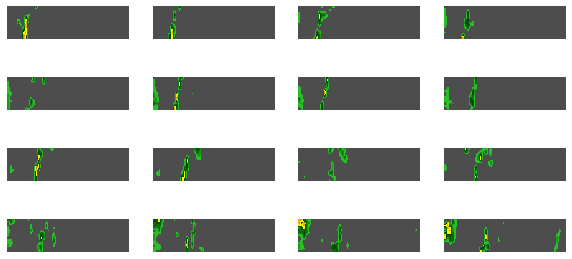

In [36]:
from display import get_cmap

vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)

fig,axs=plt.subplots(4,4,figsize=(10,5))
idx = 0
for i in range(0,4):
    for j in range(0,4):
        if idx < (input_img_seq[0].shape[2]):
            axs[i,j].imshow(input_img_seq[0][:,:,idx], cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax)
            axs[i,j].set_axis_off()
            idx+=1
plt.show()

In [9]:
class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, frame_size):
        super(ConvLSTMCell, self).__init__()
        
        self.conv2d = nn.Conv2d(in_channels=in_channels+out_channels, out_channels=4*out_channels, kernel_size=kernel_size, padding=padding)

        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size)).cuda()
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size)).cuda()
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size)).cuda()

    def forward(self, X, H_previous, C_previous):
        conv_output = self.conv2d(torch.cat([X, H_previous], dim=1))
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)
        input_gate = torch.sigmoid(i_conv + self.W_ci * C_previous )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_previous )
        C = forget_gate*C_previous + input_gate * torch.relu(C_conv)
        output_gate = torch.sigmoid(o_conv + self.W_co * C )
        H = output_gate * torch.relu(C)

        return H, C

In [10]:
class ConvLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, frame_size):
        super(ConvLSTM, self).__init__()
        self.out_channels = out_channels
        self.convLSTMCell = ConvLSTMCell(in_channels, out_channels, kernel_size, padding, frame_size)

    def forward(self, X):
        batch_size, _, seq_len, height, width = X.size()
        output = torch.zeros(batch_size, self.out_channels, seq_len, height, width).cuda()
        H = torch.zeros(batch_size, self.out_channels, height, width).cuda()
        C = torch.zeros(batch_size, self.out_channels, height, width).cuda()
        for time_step in range(seq_len):
            H, C = self.convLSTMCell(X[:,:,time_step,:,:], H, C)
            output[:,:,time_step,:,:] = H
        return output

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, num_channels, num_kernels, kernel_size, padding, frame_size, num_layers):
        super(Seq2Seq, self).__init__()
        self.sequential = nn.Sequential()
        self.sequential.add_module('convLSTM_1',ConvLSTM(in_channels=num_channels, out_channels=num_kernels, kernel_size=kernel_size, padding=padding, frame_size=frame_size))
        self.sequential.add_module('BatchNorm_1',nn.BatchNorm3d(num_features=num_kernels))
        for l in range(2, num_layers+1):
            self.sequential.add_module(f'convLSTM_{l}',ConvLSTM(in_channels=num_kernels, out_channels=num_kernels, kernel_size=kernel_size, padding=padding, frame_size=frame_size))
            self.sequential.add_module(f'BatchNorm_{l}',nn.BatchNorm3d(num_features=num_kernels))
        self.conv = nn.Conv2d(in_channels=num_kernels, out_channels=num_channels, kernel_size=kernel_size, padding=padding)

    def forward(self, X):
        batch_size, num_channels, seq_len, height, width = X.size()
        output = self.sequential(X)
        output_list=torch.zeros(batch_size,num_channels,seq_len-1,height,width).cuda()
        for time_step in range(seq_len-1):
            output_list[:,:,time_step,:,:] = nn.Sigmoid()(self.conv(output[:,:,time_step,:,:]))
        return output_list

In [12]:
net_2 = Seq2Seq(num_channels=1, num_kernels=48, kernel_size=(3,3), padding=(1,1), frame_size=(48,48), num_layers=3)
net_2.cuda()

Seq2Seq(
  (sequential): Sequential(
    (convLSTM_1): ConvLSTM(
      (convLSTMCell): ConvLSTMCell(
        (conv2d): Conv2d(49, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (BatchNorm_1): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convLSTM_2): ConvLSTM(
      (convLSTMCell): ConvLSTMCell(
        (conv2d): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (BatchNorm_2): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convLSTM_3): ConvLSTM(
      (convLSTMCell): ConvLSTMCell(
        (conv2d): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (BatchNorm_3): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv): Conv2d(48, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [13]:
total_params = sum(
	param.numel() for param in net_2.parameters()
)
total_params

417745

In [14]:
# define optimizer
optimizer = optim.Adam(net_2.parameters(), lr=0.001)

# define loss
L1Loss = nn.L1Loss()
# SmoothL1Loss = nn.SmoothL1Loss()

In [39]:
import time
epochs = 10
for epoch in range(epochs):
    running_loss = 0.
    for input_data in train_dataloader:
        input_img_seq, output_img_seq = input_data

        input_img_seq = input_img_seq.type(torch.cuda.FloatTensor).unsqueeze(1)
        output_img_seq = output_img_seq.type(torch.cuda.FloatTensor)
        optimizer.zero_grad()

        t0 = time.time()
        output = net_2(input_img_seq)
        loss = L1Loss(output.squeeze(1)[:,-1,:,:],output_img_seq[:,-1,:,:])
        loss.backward()
        optimizer.step()
        t1 = time.time()
        running_loss += loss.item()
        print('Timer: %.4f sec.' % (t1 - t0))
        print('iter ' + repr(epoch) + ' || Loss: %.4f ' % \
                (running_loss))

Timer: 0.9175 sec.
iter 0 || Loss: 10.8049 
Timer: 0.9532 sec.
iter 0 || Loss: 22.1372 
Timer: 1.0492 sec.
iter 0 || Loss: 39.8024 
Timer: 0.8452 sec.
iter 0 || Loss: 65.6912 
Timer: 0.9656 sec.
iter 0 || Loss: 91.0598 
Timer: 0.9356 sec.
iter 0 || Loss: 102.3130 
Timer: 1.0616 sec.
iter 0 || Loss: 120.4918 
Timer: 0.9170 sec.
iter 0 || Loss: 138.7527 
Timer: 0.8519 sec.
iter 0 || Loss: 151.6415 
Timer: 0.9953 sec.
iter 0 || Loss: 171.8419 
Timer: 0.8957 sec.
iter 0 || Loss: 203.0634 
Timer: 0.9117 sec.
iter 0 || Loss: 220.1098 
Timer: 0.8726 sec.
iter 0 || Loss: 234.0349 
Timer: 1.0412 sec.
iter 0 || Loss: 252.6788 
Timer: 0.7669 sec.
iter 0 || Loss: 265.4454 
Timer: 0.9529 sec.
iter 0 || Loss: 286.6184 
Timer: 0.9854 sec.
iter 0 || Loss: 305.8898 
Timer: 1.0114 sec.
iter 0 || Loss: 323.1293 
Timer: 0.8817 sec.
iter 0 || Loss: 335.4227 
Timer: 1.0432 sec.
iter 0 || Loss: 342.7151 
Timer: 0.9056 sec.
iter 0 || Loss: 366.7134 
Timer: 0.8627 sec.
iter 0 || Loss: 375.4913 
Timer: 0.8675 s

KeyboardInterrupt: 

In [19]:
torch.save(net_2,'ConvLSTM_12_2_23.pth')

In [38]:
output.shape

torch.Size([8, 1, 12, 48, 48])

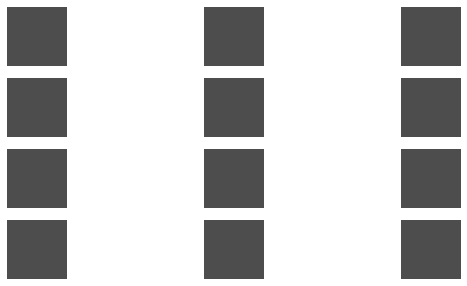

In [25]:
fig,axs=plt.subplots(4,3,figsize=(10,5))
plot_output = output.squeeze(1).cpu().detach().numpy()
idx = 0
for i in range(0,4):
    for j in range(0,3):
        if idx < (12):
            axs[i,j].imshow(plot_output[0][idx,:,:], cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax)
            axs[i,j].set_axis_off()
            idx+=1
plt.show()

In [23]:
sevir_test_dataset = SevirDataset(root='',type='test')
test_dataloader = data.DataLoader(sevir_test_dataset, batch_size=8, shuffle=True)


In [27]:
input_img_seq, output_img_seq = next(iter(test_dataloader))
net = torch.load('ConvLSTM_12_2_23.pth')
input_img_seq = input_img_seq.type(torch.cuda.FloatTensor).unsqueeze(1)
output = net_2(input_img_seq)

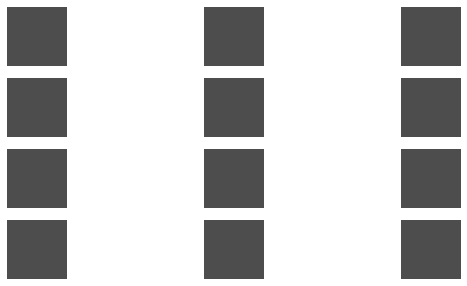

In [28]:
fig,axs=plt.subplots(4,3,figsize=(10,5))
plot_output = output.squeeze(1).cpu().detach().numpy()
idx = 0
for i in range(0,4):
    for j in range(0,3):
        if idx < (12):
            axs[i,j].imshow(plot_output[0][idx,:,:], cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax)
            axs[i,j].set_axis_off()
            idx+=1
plt.show()